# Code to generate all figures on freeze events used in the paper
## note this is spread across multiple figures
## TODO: Update the specific list once we are done

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
# setup all the imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import yaml
import urllib.request
import matplotlib.font_manager
flist = matplotlib.font_manager.get_font_names()
from tempfile import NamedTemporaryFile
import urllib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.patches as patches
from extremeweatherbench import evaluate, utils, cases, defaults, inputs, metrics
sns.set_theme(style='whitegrid')
from shapely.geometry import Polygon
import shapely
from pathlib import Path
import multiprocessing
from matplotlib.patches import Patch
import xarray as xr
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
# make the basepath - change this to your local path
basepath = Path.home() / 'ExtremeWeatherBench' / ''
basepath = str(basepath) + '/'

In [2]:
# make a global color palatte so things are consistent across plots
sns_palette = sns.color_palette("tab10")
sns.set_style("whitegrid")

fourv2_color = sns_palette[0]
gc_color = sns_palette[1]
pangu_color = sns_palette[2]
hres_color = sns_palette[3]

In [3]:
# setup the templates to load in the data

# Forecast Examples
cira_freeze_forecast_FOURv2 = inputs.KerchunkForecast(
    source="gs://extremeweatherbench/FOUR_v200_IFS.parq",
    variables=[
        "surface_air_temperature",
    ],
    variable_mapping={
        "t2": "surface_air_temperature",
    },
    storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
    preprocess=defaults._preprocess_bb_cira_forecast_dataset,
    name="FOURv2_IFS_CIRA",
)

cira_freeze_forecast_GC = inputs.KerchunkForecast(
    source="gs://extremeweatherbench/GRAP_v100_IFS.parq",
    variables=[
        "surface_air_temperature",
    ],
    variable_mapping={
        "t2": "surface_air_temperature",
    },
    storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
    preprocess=defaults._preprocess_bb_cira_forecast_dataset,
    name="GraphCast_IFS_CIRA",
)

cira_freeze_forecast_PANG = inputs.KerchunkForecast(
    source="gs://extremeweatherbench/PANG_v100_IFS.parq",
    variables=[
        "surface_air_temperature",
    ],
    variable_mapping={
        "t2": "surface_air_temperature",
    },
    storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
    preprocess=defaults._preprocess_bb_cira_forecast_dataset,
    name="Pangu_IFS_CIRA",
)


hres_forecast = inputs.ZarrForecast(
    source="gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr",
    variables=[
        "surface_air_temperature",
    ],
    variable_mapping=inputs.HRES_metadata_variable_mapping,
    storage_options={"remote_options": {"anon": True}},
    name="HRES",
)


FOURv2_GHCN_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="freeze",
        metric_list=[
            metrics.MinimumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
        ],
        target=defaults.ghcn_heatwave_target,
        forecast=cira_freeze_forecast_FOURv2, 
    ),
]

FOURv2_ERA5_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="freeze",
        metric_list=[
            metrics.MinimumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
        ],
        target=defaults.era5_heatwave_target,
        forecast=cira_freeze_forecast_FOURv2, 
    ),
]

GC_GHCN_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="freeze",
        metric_list=[
            metrics.MinimumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
        ],
        target=defaults.ghcn_heatwave_target,
        forecast=cira_freeze_forecast_GC, 
    ),
]

GC_ERA5_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="freeze",
        metric_list=[
            metrics.MinimumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
        ],
        target=defaults.era5_heatwave_target,
        forecast=cira_freeze_forecast_GC, 
    ),
]

PANG_GHCN_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="freeze",
        metric_list=[
            metrics.MinimumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
        ],
        target=defaults.ghcn_heatwave_target,
        forecast=cira_freeze_forecast_PANG, 
    ),
]

PANG_ERA5_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="freeze",
        metric_list=[
            metrics.MinimumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
        ],
        target=defaults.era5_heatwave_target,
        forecast=cira_freeze_forecast_PANG, 
    ),
]

HRES_GHCN_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="freeze",
        metric_list=[
            metrics.MinimumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
        ],
        target=defaults.ghcn_heatwave_target,
        forecast=hres_forecast,
    ),
]

HRES_ERA5_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="freeze",
        metric_list=[
            metrics.MinimumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
        ],
        target=defaults.era5_heatwave_target,
        forecast=hres_forecast,
    ),
]


In [4]:
# load in all of the events in the yaml file
case_dict = utils.load_events_yaml()
freeze_test = {"cases": case_dict["cases"]}

# turn the dictionary into a list of case objects ()
ewb_cases = cases.load_individual_cases(case_dict)

# create the evaluation objects for each model
ewb_fourv2_ghcn = evaluate.ExtremeWeatherBench(freeze_test, FOURv2_GHCN_EVALUATION_OBJECTS)
ewb_fourv2_era5 = evaluate.ExtremeWeatherBench(freeze_test, FOURv2_ERA5_EVALUATION_OBJECTS)

ewb_gc_ghcn = evaluate.ExtremeWeatherBench(freeze_test, GC_GHCN_EVALUATION_OBJECTS)
ewb_gc_era5 = evaluate.ExtremeWeatherBench(freeze_test, GC_ERA5_EVALUATION_OBJECTS)

ewb_pang_ghcn = evaluate.ExtremeWeatherBench(freeze_test, PANG_GHCN_EVALUATION_OBJECTS)
ewb_pang_era5 = evaluate.ExtremeWeatherBench(freeze_test, PANG_ERA5_EVALUATION_OBJECTS)

ewb_hres_ghcn = evaluate.ExtremeWeatherBench(freeze_test, HRES_GHCN_EVALUATION_OBJECTS)
ewb_hres_era5 = evaluate.ExtremeWeatherBench(freeze_test, HRES_ERA5_EVALUATION_OBJECTS)

This function is deprecated and will be removed in a future release. Please use cases.load_ewb_events_yaml_into_case_collection instead.
This function is deprecated and will be removed in a future release. Please use cases.read_incoming_yaml instead.


In [5]:
# load in the results for all heat waves in parallel
# this will take awhile to run if you do them all in one code box so I commented most of them out here and copied them below
n_threads_per_process = 4
n_processes = max(1, multiprocessing.cpu_count() // n_threads_per_process)

fourv2_ghcn_results = ewb_fourv2_ghcn.run(parallel=True, n_jobs=n_processes, pre_compute=True)
fourv2_era5_results = ewb_fourv2_era5.run(parallel=True, n_jobs=n_processes, pre_compute=True)

gc_ghcn_results = ewb_gc_ghcn.run(parallel=True, n_jobs=n_processes, pre_compute=True)
gc_era5_results = ewb_gc_era5.run(parallel=True, n_jobs=n_processes, pre_compute=True)

pang_ghcn_results = ewb_pang_ghcn.run(parallel=True, n_jobs=n_processes, pre_compute=True)
pang_era5_results = ewb_pang_era5.run(parallel=True, n_jobs=n_processes, pre_compute=True)

hres_ghcn_results = ewb_hres_ghcn.run(parallel=True, n_jobs=n_processes, pre_compute=True)
hres_era5_results = ewb_hres_era5.run(parallel=True, n_jobs=n_processes, pre_compute=True)

  0%|          | 0/14 [00:00<?, ?it/s]

Forecast dataset for case 91 has no data for case time range 2021-03-04 18:00:00 to 2021-03-10 18:00:00.
Forecast dataset for case 30 has no data for case time range 2021-02-10 12:00:00 to 2021-02-22 00:00:00.


  0%|          | 0/14 [00:00<?, ?it/s]

Forecast dataset for case 91 has no data for case time range 2021-03-04 18:00:00 to 2021-03-10 18:00:00.
Forecast dataset for case 30 has no data for case time range 2021-02-10 12:00:00 to 2021-02-22 00:00:00.


  0%|          | 0/14 [00:00<?, ?it/s]

Forecast dataset for case 30 has no data for case time range 2021-02-10 12:00:00 to 2021-02-22 00:00:00.
Forecast dataset for case 91 has no data for case time range 2021-03-04 18:00:00 to 2021-03-10 18:00:00.


  0%|          | 0/14 [00:00<?, ?it/s]

Forecast dataset for case 91 has no data for case time range 2021-03-04 18:00:00 to 2021-03-10 18:00:00.
Forecast dataset for case 30 has no data for case time range 2021-02-10 12:00:00 to 2021-02-22 00:00:00.


  0%|          | 0/14 [00:00<?, ?it/s]

Forecast dataset for case 30 has no data for case time range 2021-02-10 12:00:00 to 2021-02-22 00:00:00.
Forecast dataset for case 91 has no data for case time range 2021-03-04 18:00:00 to 2021-03-10 18:00:00.


  0%|          | 0/14 [00:00<?, ?it/s]

Forecast dataset for case 91 has no data for case time range 2021-03-04 18:00:00 to 2021-03-10 18:00:00.
Forecast dataset for case 30 has no data for case time range 2021-02-10 12:00:00 to 2021-02-22 00:00:00.


  0%|          | 0/14 [00:00<?, ?it/s]

Forecast dataset for case 32 has no data for case time range 2023-12-02 06:00:00 to 2023-12-08 06:00:00.
Forecast dataset for case 33 has no data for case time range 2023-12-15 06:00:00 to 2023-12-26 18:00:00.
Forecast dataset for case 89 has no data for case time range 2024-01-11 12:00:00 to 2024-01-20 00:00:00.
Forecast dataset for case 92 has no data for case time range 2024-01-01 06:00:00 to 2024-01-09 12:00:00.
Forecast dataset for case 96 has no data for case time range 2024-04-02 00:00:00 to 2024-04-08 00:00:00.
Forecast dataset for case 94 has no data for case time range 2024-04-16 12:00:00 to 2024-04-27 12:00:00.
Forecast dataset for case 95 has no data for case time range 2024-01-20 00:00:00 to 2024-02-04 18:00:00.


  0%|          | 0/14 [00:00<?, ?it/s]

Forecast dataset for case 32 has no data for case time range 2023-12-02 06:00:00 to 2023-12-08 06:00:00.
Forecast dataset for case 33 has no data for case time range 2023-12-15 06:00:00 to 2023-12-26 18:00:00.
Forecast dataset for case 89 has no data for case time range 2024-01-11 12:00:00 to 2024-01-20 00:00:00.
Forecast dataset for case 92 has no data for case time range 2024-01-01 06:00:00 to 2024-01-09 12:00:00.
Forecast dataset for case 94 has no data for case time range 2024-04-16 12:00:00 to 2024-04-27 12:00:00.
Forecast dataset for case 96 has no data for case time range 2024-04-02 00:00:00 to 2024-04-08 00:00:00.
Forecast dataset for case 95 has no data for case time range 2024-01-20 00:00:00 to 2024-02-04 18:00:00.


In [6]:
# save the results so I don't have to keep re-running
fourv2_ghcn_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_fourv2_ghcn_freeze_results.pkl')
fourv2_era5_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_fourv2_era5_freeze_results.pkl')

pang_ghcn_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_pang_ghcn_freeze_results.pkl')
pang_era5_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_pang_era5_freeze_results.pkl')

hres_ghcn_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_hres_ghcn_freeze_results.pkl')
hres_era5_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_hres_era5_freeze_results.pkl')

gc_era5_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_gc_era5_freeze_results.pkl')
gc_ghcn_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_gc_ghcn_freeze_results.pkl')

In [5]:
# load the results back in
fourv2_ghcn_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_fourv2_ghcn_freeze_results.pkl')
fourv2_era5_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_fourv2_era5_freeze_results.pkl')

pang_ghcn_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_pang_ghcn_freeze_results.pkl')
pang_era5_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_pang_era5_freeze_results.pkl')

hres_ghcn_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_hres_ghcn_freeze_results.pkl')
hres_era5_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_hres_era5_freeze_results.pkl')

gc_era5_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_gc_era5_freeze_results.pkl')
gc_ghcn_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_gc_ghcn_freeze_results.pkl')

In [ ]:
# get the unique list of metrics
unique_metrics = fourv2_ghcn_results['metric'].unique()
print(unique_metrics)

In [6]:
# group the results by metric and lead time and take the mean across cases
fourv2_ghcn_group = fourv2_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
fourv2_ghcn_group = fourv2_ghcn_group.reset_index()

fourv2_era5_group = fourv2_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
fourv2_era5_group = fourv2_era5_group.reset_index()

gc_ghcn_group = gc_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
gc_ghcn_group = gc_ghcn_group.reset_index()

gc_era5_group = gc_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
gc_era5_group = gc_era5_group.reset_index()

pang_ghcn_group = pang_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
pang_ghcn_group = pang_ghcn_group.reset_index()

pang_era5_group = pang_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
pang_era5_group = pang_era5_group.reset_index()

hres_ghcn_group = hres_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
hres_ghcn_group = hres_ghcn_group.reset_index()

hres_era5_group = hres_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
hres_era5_group = hres_era5_group.reset_index()



In [ ]:
def plot_results_by_metric(metric='rmse', filename=None, title='RMSE for All Heat Waves', forecast_hour=None):
    # make the pivot table so we can plot by lead time
    fourv2_ghcn_pivot = fourv2_ghcn_group[fourv2_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')
    fourv2_era_pivot = fourv2_era5_group[fourv2_era5_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    pang_ghcn_pivot = pang_ghcn_group[pang_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')
    pang_era5_pivot = pang_era5_group[pang_era5_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    hres_ghcn_pivot = hres_ghcn_group[hres_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')
    hres_era5_pivot = hres_era5_group[hres_era5_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    gc_ghcn_pivot = gc_ghcn_group[gc_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')
    gc_era5_pivot = gc_era5_group[gc_era5_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    if (forecast_hour == "zeroz"):
        # extract the 0z runs
        time_diff = hres_era5_pivot.columns.seconds % 86400 == 0
        my_idxs = [idx for idx, n in enumerate(time_diff) if n]
    elif (forecast_hour == "twelvez"):
        # extract the 12z runs
        time_diff = hres_era5_pivot.columns.seconds % 86400 == 43200
        my_idxs = [idx for idx, n in enumerate(time_diff) if n]
        
    if (forecast_hour is not None):
        # subset down 
        fourv2_ghcn_pivot = fourv2_ghcn_pivot.iloc[:, my_idxs]
        fourv2_era_pivot = fourv2_era_pivot.iloc[:, my_idxs]

        pang_ghcn_pivot = pang_ghcn_pivot.iloc[:, my_idxs]
        pang_era5_pivot = pang_era5_pivot.iloc[:, my_idxs]    

        hres_ghcn_pivot = hres_ghcn_pivot.iloc[:, my_idxs]
        hres_era5_pivot = hres_era5_pivot.iloc[:, my_idxs]
   
        gc_era5_pivot = gc_era5_pivot.iloc[:, my_idxs]
        gc_ghcn_pivot = gc_ghcn_pivot.iloc[:, my_idxs]
        

    # make the plots
    sns.set_theme(style='whitegrid')
    sns_palette = sns.color_palette("tab10")
    fig, ax = plt.subplots(figsize=(16,4))
    fourv2_ghcn_values = fourv2_ghcn_pivot.loc[metric].values
    fourv2_era5_values = fourv2_era_pivot.loc[metric].values
    pang_ghcn_values = pang_ghcn_pivot.loc[metric].values
    pang_era5_values = pang_era5_pivot.loc[metric].values
    hres_ghcn_values = hres_ghcn_pivot.loc[metric].values
    hres_era5_values = hres_era5_pivot.loc[metric].values
    gc_ghcn_values = gc_ghcn_pivot.loc[metric].values
    gc_era5_values = gc_era5_pivot.loc[metric].values

    plt.plot(np.flip(fourv2_ghcn_values), color=fourv2_color, label='FourCastNet V2 GHCN', linewidth=2)
    plt.plot(np.flip(fourv2_era5_values), color=fourv2_color, linestyle='--', label='FourCastNet V2 ERA5', linewidth=2)

    plt.plot(np.flip(gc_ghcn_values), color=gc_color, label='GraphCast GHCN', linewidth=2)
    plt.plot(np.flip(gc_era5_values), color=gc_color, linestyle='--', label='GraphCast ERA5', linewidth=2)  

    plt.plot(np.flip(pang_ghcn_values), color=pangu_color, label='Pangu Weather GHCN', linewidth=2)
    plt.plot(np.flip(pang_era5_values), color=pangu_color, linestyle='--', label='Pangu Weather ERA5', linewidth=2)  

    plt.plot(np.flip(hres_ghcn_values), color=hres_color, label='HRES GHCN', linewidth=2)
    plt.plot(np.flip(hres_era5_values), color=hres_color, linestyle='--', label='HRES ERA5', linewidth=2)


    # make the xticklabels more readable and show every other one
    # print(np.arange(0, len(merged_pivot.columns), 2))
    # print(merged_pivot.columns[::2])
    ax.set_xticks(rotation=90, labels=np.flip(fourv2_ghcn_pivot.columns), ticks=np.arange(0, len(fourv2_ghcn_pivot.columns), 1))
    #ax.set_xticks(ticks=np.arange(0, len(merged_pivot.columns), 2))

    ax.set_ylabel('Celsius')
    ax.set_xlabel('Initialization Time')
    plt.title(title)
    #ax.grid(True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=0.5)
    plt.legend(loc='best', fontsize=12)

    if (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)


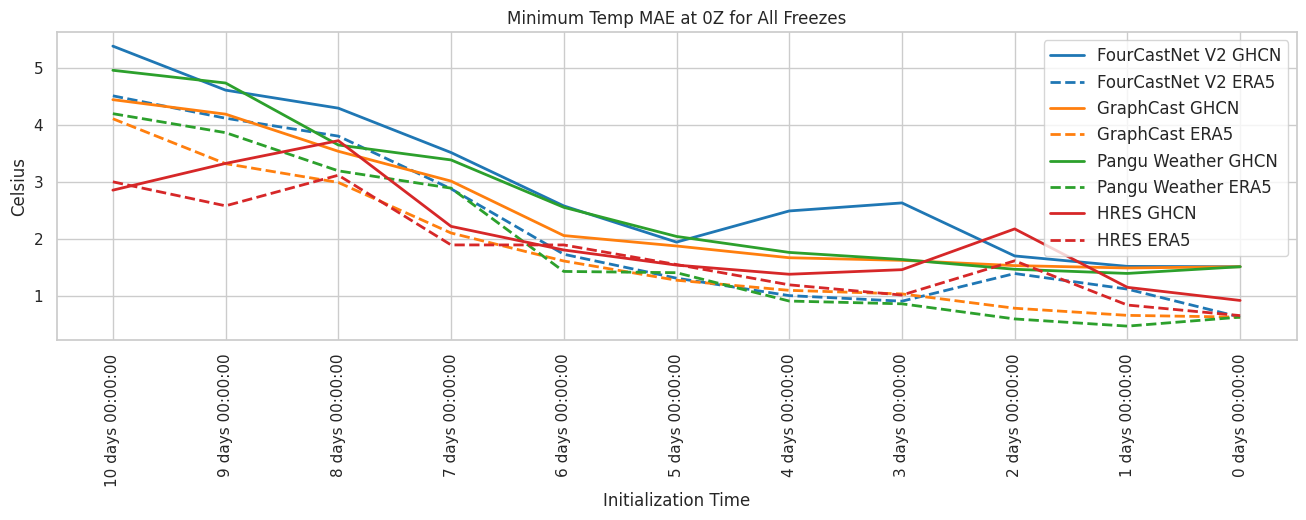

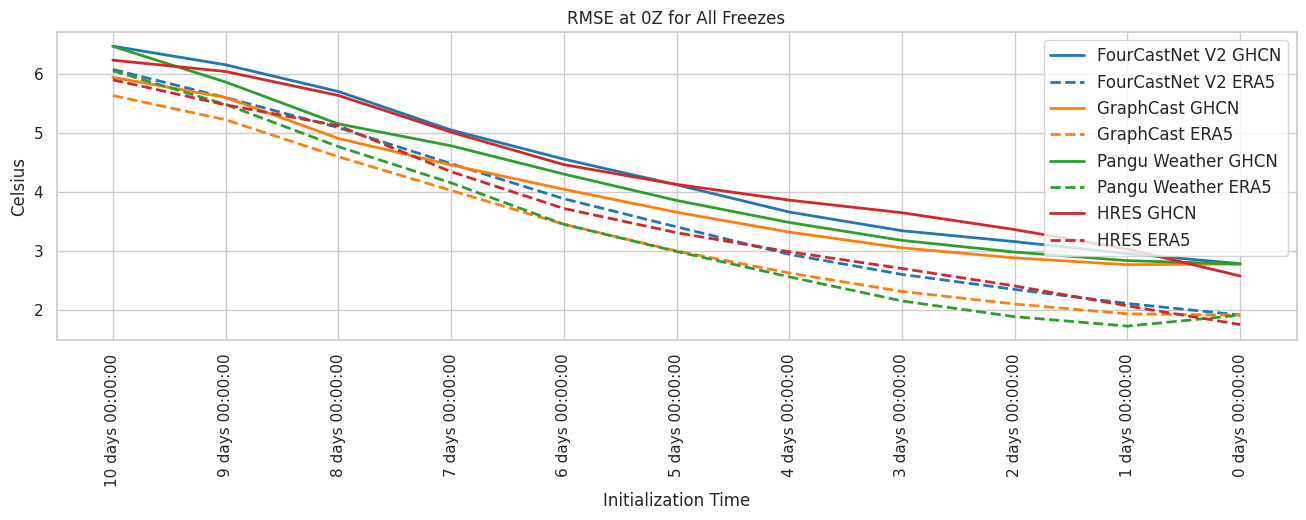

In [9]:
plot_results_by_metric(metric='minimum_mae', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_freeze_0z.png', 
                       title='Minimum Temp MAE at 0Z for All Freezes', forecast_hour="zeroz")
plot_results_by_metric(metric='rmse', filename=basepath + 'docs/notebooks/figs/figure2_part2_rmse_freeze.png', 
                       title='RMSE at 0Z for All Freezes', forecast_hour="zeroz")



# subset the data into regions

In [8]:
# helper function to convert a bounding box tuple to a shapely Polygon
def get_polygon_from_bounding_box(bounding_box):
    """Convert a bounding box tuple to a shapely Polygon."""
    if bounding_box is None:
        return None
    left_lon, right_lon, bot_lat, top_lat = bounding_box
    return Polygon(
        [
            (left_lon, bot_lat),
            (right_lon, bot_lat),
            (right_lon, top_lat),
            (left_lon, top_lat),
            (left_lon, bot_lat),
        ]
    )

# North America
na_bounding_box = [-172, -45, 7, 85]
na_bounding_box_polygon = get_polygon_from_bounding_box(na_bounding_box)

# Europe bounding box
eu_bounding_box = [50, -15, 15, 75]
eu_bounding_box_polygon = get_polygon_from_bounding_box(eu_bounding_box)

# australia bounding box
au_bounding_box = [110, 180, -50, -10]
au_bounding_box_polygon = get_polygon_from_bounding_box(au_bounding_box)


In [9]:
# plot the boxes on a global map so we can see where they are

# helper function to plot a polygon on a cartopy axis
def plot_polygon(polygon, ax, color='yellow', alpha=0.5, my_zorder=1):
    """Plot a shapely Polygon on a Cartopy axis."""
    if polygon is None:
        return
    patch = patches.Polygon(
        polygon.exterior.coords,
        closed=True,
        facecolor=color,
        edgecolor=color,
        alpha=alpha,
        linewidth=2,
        zorder=my_zorder,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(patch)

# helper function to plot a polygon on a cartopy axis
def plot_polygon_outline(polygon, ax, color='yellow', alpha=0.5, my_zorder=1):
    """Plot a shapely Polygon on a Cartopy axis."""
    if polygon is None:
        return
    patch = patches.Polygon(
        polygon.exterior.coords,
        closed=True,
        facecolor='none',
        edgecolor=color,
        alpha=alpha,
        linewidth=2,
        zorder=my_zorder,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(patch)


# main plotting function for plotting all cases
def plot_boxes(box_list, box_names, title, filename=None):
    # plot all cases on one giant world map
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
        
    # Add coastlines and gridlines
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')
    ax.add_feature(cfeature.RIVERS, edgecolor='black')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='black', alpha=1, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # Define colors for each event type
    # use seaborn color palette for colorblind friendly colors
    sns_palette = sns.color_palette("tab10")
    sns.set_style("whitegrid")

    # Plot boxes for each case
    for box in box_list:
        plot_polygon_outline(box, ax, color='blue', alpha=1)

    plt.legend(loc='lower left', fontsize=12)
    ax.set_title(title, loc='left', fontsize=20)
    
    # save if there is a filename specified (otherwise the user just wants to see the plot)
    if filename is not None:
        plt.savefig(filename, transparent=False, bbox_inches='tight', dpi=300)

/tmp/ipykernel_1123883/3761302962.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=12)


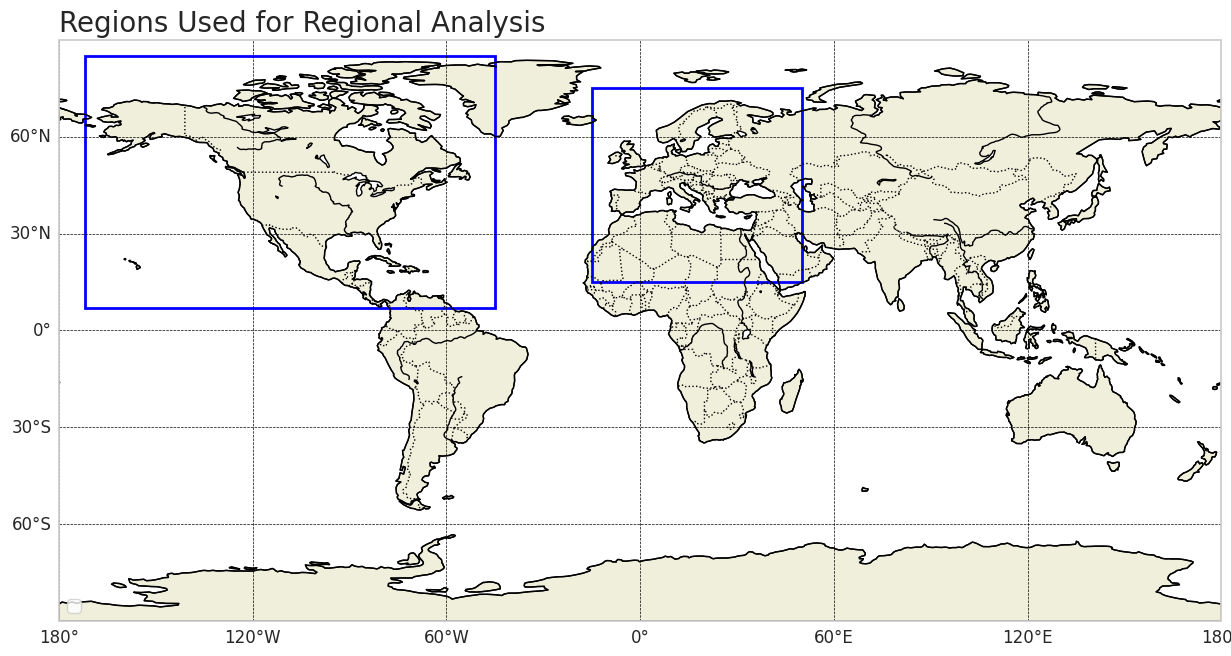

In [12]:
plot_boxes(
    box_list=[na_bounding_box_polygon, eu_bounding_box_polygon],
    box_names=['North America', 'Europe', 'Australia'],
    title='Regions Used for Regional Analysis',
    filename=basepath + 'docs/notebooks/figure3_part1_regions.png'
)

In [10]:
# main plotting function for plotting all cases
def plot_all_cases(ewb_cases, event_type=None, filename=None, bounding_box=None, fill_boxes=False, event_id=None):
    """A function to plot all cases
    Args:
        ewb_cases (list): A list of cases to plot.
        event_type (str): The type of event to plot. If None, all events will be plotted).
        filename (str): The name of the file to save the plot. If None, the plot will not be saved.
        bounding_box (tuple): A tuple of the form (min_lon, min_lat, max_lon, max_lat) to set the bounding box for the plot. If None, the full world map will be plotted.
    """
    # plot all cases on one giant world map
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # plot the full map or a subset if bounding_box is specified
    if (bounding_box is None):
        ax.set_global()
    else:
        ax.set_extent(bounding_box, crs=ccrs.PlateCarree())
    
    # save the bounding box polygon to subset the counts later
    if (bounding_box is not None):
        bounding_box_polygon = get_polygon_from_bounding_box(bounding_box)
        #plot_polygon(bounding_box_polygon, ax, color='yellow', alpha=0.5)
        
    # Add coastlines and gridlines
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')
    ax.add_feature(cfeature.RIVERS, edgecolor='black')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # Define colors for each event type
    # use seaborn color palette for colorblind friendly colors
    sns_palette = sns.color_palette("tab10")
    sns.set_style("whitegrid")

    # event_colors = {
    #     'heat_wave': 'firebrick',
    #     'tropical_cyclone': 'darkorange',
    #     'severe_convection': 'orchid',
    #     'atmospheric_river': 'mediumseagreen',
    #     'freeze': 'royalblue',   
    # }
    event_colors = {
            'freeze': sns_palette[0],  
            'heat_wave': sns_palette[3],
            'tropical_cyclone': sns_palette[1],
            'severe_convection': sns_palette[5],
            'atmospheric_river': sns_palette[7],
        }

    # Initialize counts for each event type
    counts_by_type = dict({'freeze': 0, 'heat_wave': 0, 'severe_convection': 0, 'atmospheric_river': 0, 'tropical_cyclone': 0})
    zorders = {'freeze': 10, 'heat_wave': 9, 'atmospheric_river': 2, 'tropical_cyclone': 1, 'severe_convection': 0}
    alphas = {'freeze': 0.2, 'heat_wave': 0.2, 'atmospheric_river': 0.2, 'tropical_cyclone': 0.2, 'severe_convection': 0.05}

    # Plot boxes for each case
    for indiv_case in ewb_cases.cases:
        # Get color based on event type
        indiv_event_type = indiv_case.event_type
        color = event_colors.get(indiv_event_type, 'gray')  # Default to gray if event type not found

        # check if the case is inside the bounding box
        if bounding_box is not None:
            if (not shapely.intersects(indiv_case.location.geopandas.geometry[0], bounding_box_polygon)):
                #print(f"Skipping case {indiv_case.case_id_number} as it is outside the bounding box.")
                continue
        
        # Plot the case geopandas info
        if (event_type is None or indiv_event_type == event_type and event_id is None) or (event_id is not None and indiv_case.case_id_number == event_id):
            if (fill_boxes):
                # to handle wrapping around the prime meridian, we can't use geopandas plot (and besides it is slow)
                # instead we have multi-polygon patches if it wraps around and we need to plot each polygon separately
                if isinstance(indiv_case.location.geopandas.geometry.iloc[0], shapely.geometry.MultiPolygon):
                    for poly in indiv_case.location.geopandas.geometry.iloc[0].geoms:
                        plot_polygon(poly, ax, color=color, alpha=alphas[indiv_event_type], my_zorder=zorders[indiv_event_type])
                else:
                    plot_polygon(indiv_case.location.geopandas.geometry.iloc[0], ax, color=color, 
                                alpha=alphas[indiv_event_type], my_zorder=zorders[indiv_event_type])
            else:
                # to handle wrapping around the prime meridian, we can't use geopandas plot (and besides it is slow)
                # instead we have multi-polygon patches if it wraps around and we need to plot each polygon separately
                if isinstance(indiv_case.location.geopandas.geometry.iloc[0], shapely.geometry.MultiPolygon):
                    for poly in indiv_case.location.geopandas.geometry.iloc[0].geoms:
                        plot_polygon_outline(poly, ax, color=color, alpha=1, my_zorder=zorders[indiv_event_type])
                else:
                    plot_polygon_outline(indiv_case.location.geopandas.geometry.iloc[0], ax, color=color, 
                                alpha=1, my_zorder=zorders[indiv_event_type])

            # count the events by type
            counts_by_type[indiv_event_type] += 1

        
    # Create a custom legend for event types
    if (event_type is not None):
        # if we are only plotting one event type, only show that in the legend
        legend_elements = [
            Patch(facecolor=event_colors[event_type], alpha=0.9, label=f'{event_type.replace("_", " ").title()} (n = %d)' % counts_by_type[event_type]),
        ]
    else:
        # otherwise show all event types in the legend
        legend_elements = [
            Patch(facecolor=event_colors['heat_wave'], alpha=0.9, label='Heat Wave (n = %d)' % counts_by_type['heat_wave']),
            Patch(facecolor=event_colors['freeze'], alpha=0.9, label='Freeze (n = %d)' % counts_by_type['freeze']),
            Patch(facecolor=event_colors['severe_convection'], alpha=0.9, label='Convection (n = %d)' % counts_by_type['severe_convection']),
            Patch(facecolor=event_colors['atmospheric_river'], alpha=0.9, label='Atmospheric River (n = %d)' % counts_by_type['atmospheric_river']),
            Patch(facecolor=event_colors['tropical_cyclone'], alpha=0.9, label='Tropical Cyclone (n = %d)' % counts_by_type['tropical_cyclone']),
        ]

    # Create a larger legend by specifying a larger font size in the prop dictionary
    ax.legend(handles=legend_elements, loc='lower left', framealpha=1, frameon=True, borderpad=0.5, handletextpad=0.8, handlelength=2.5)
    if (event_type is None):
        title = 'ExtremeWeatherBench Cases (n = %d)' % sum(counts_by_type.values())
    else:
        title = f'ExtremeWeatherBench Cases: {event_type.replace("_", " ").title()} (n = %d)' % counts_by_type[event_type]

    if (event_id is not None):
        title = f'ExtremeWeatherBench Case ID: {event_id}'
    
    ax.set_title(title, loc='left', fontsize=20)
    
    # save if there is a filename specified (otherwise the user just wants to see the plot)
    if filename is not None:
        plt.savefig(filename, transparent=False, bbox_inches='tight', dpi=300)

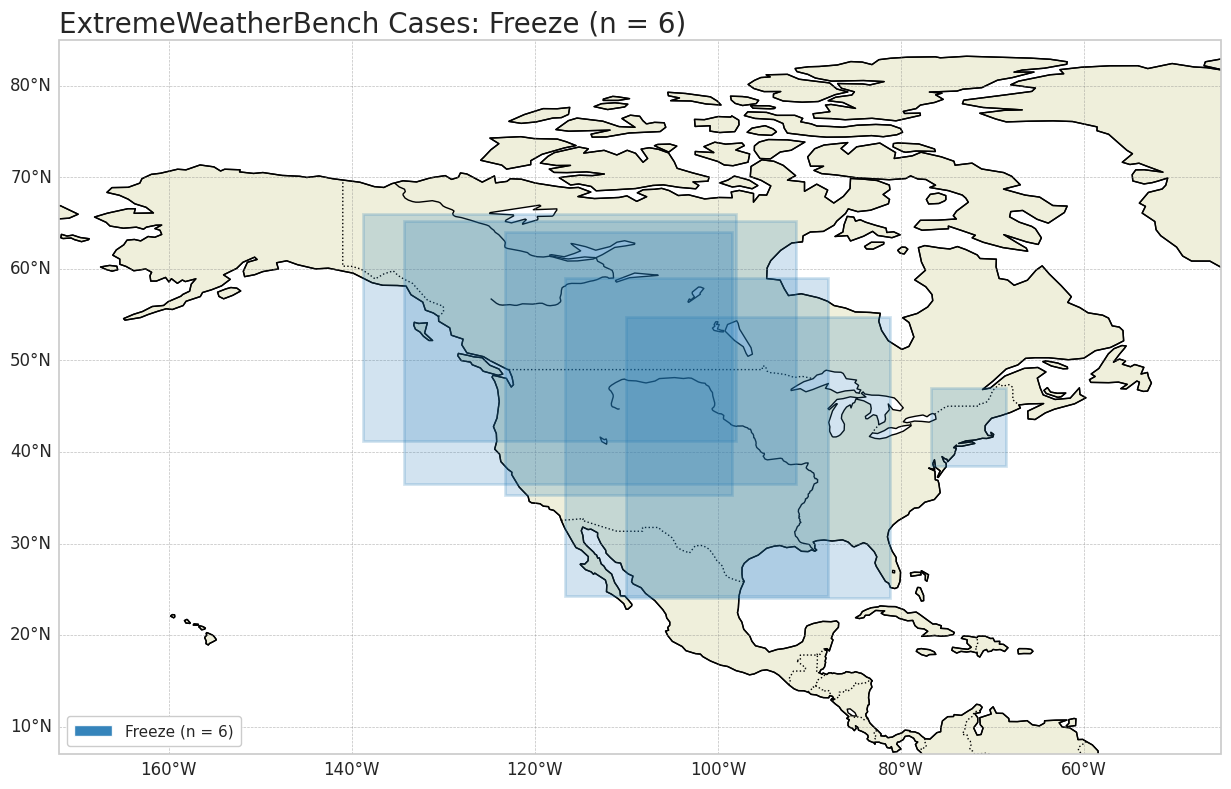

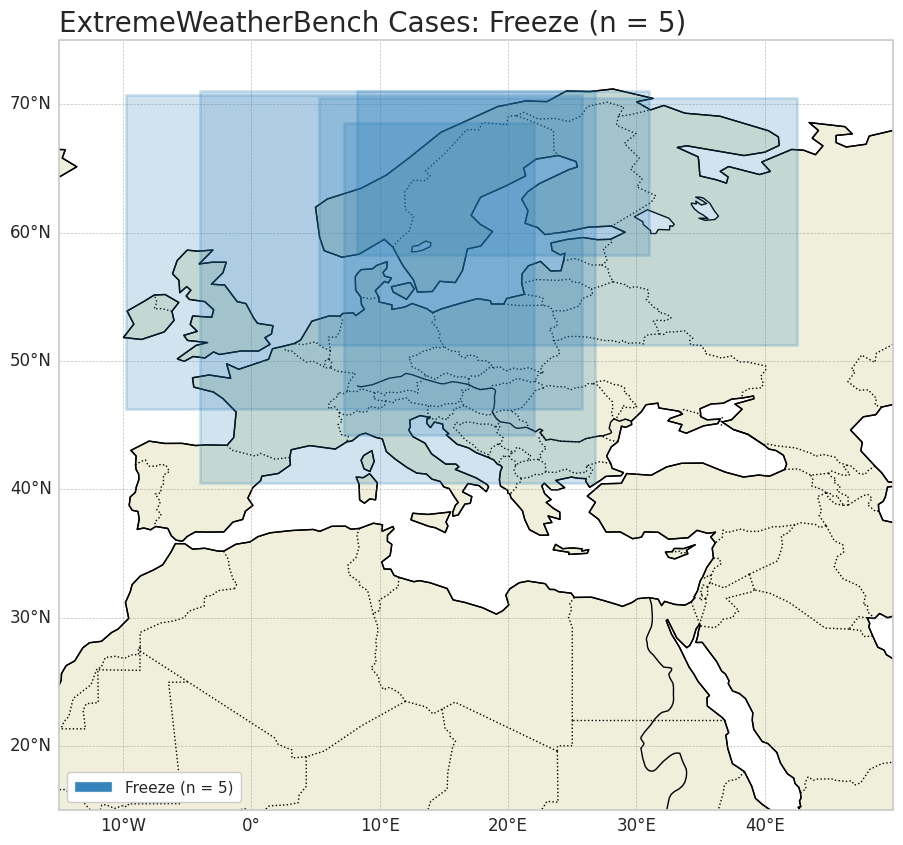

In [14]:
# plot the cases for the regions we are analyzing
plot_all_cases(ewb_cases, event_type='freeze', bounding_box=na_bounding_box, 
               filename=basepath + 'docs/notebooks/figs/extreme_weather_freeze_cases_NA.png', fill_boxes=True)

plot_all_cases(ewb_cases, event_type='freeze', bounding_box=eu_bounding_box, 
               filename=basepath + 'docs/notebooks/figs/extreme_weather_freeze_cases_EU.png', fill_boxes=True)

In [11]:
# make the list of cases by region
na_cases = list()
eu_cases = list()

for case in ewb_fourv2_era5.case_operators:
    #print(heat_case.case_metadata)

    my_case = case.case_metadata

    # collect the North America, Europe, and Australia cases
    if (shapely.intersects(my_case.location.geopandas.geometry[0], na_bounding_box_polygon)):
        na_cases.append(my_case.case_id_number)
    elif (shapely.intersects(my_case.location.geopandas.geometry[0], eu_bounding_box_polygon)):
        eu_cases.append(my_case.case_id_number)
    

print(f'North America Cases: {na_cases}')
print(f'Europe Cases: {eu_cases}')

North America Cases: [30, 31, 35, 89, 90, 91]
Europe Cases: [32, 92, 93, 94, 96]


In [12]:
# make all the subsets
na_fourv2_era5_results = fourv2_era5_results[fourv2_era5_results['case_id_number'].isin(na_cases)]
eu_fourv2_era5_results = fourv2_era5_results[fourv2_era5_results['case_id_number'].isin(eu_cases)]

na_fourv2_ghcn_results = fourv2_ghcn_results[fourv2_ghcn_results['case_id_number'].isin(na_cases)]
eu_fourv2_ghcn_results = fourv2_ghcn_results[fourv2_ghcn_results['case_id_number'].isin(eu_cases)]

na_pang_era5_results = pang_era5_results[pang_era5_results['case_id_number'].isin(na_cases)]
eu_pang_era5_results = pang_era5_results[pang_era5_results['case_id_number'].isin(eu_cases)]

na_pang_ghcn_results = pang_ghcn_results[pang_ghcn_results['case_id_number'].isin(na_cases)]
eu_pang_ghcn_results = pang_ghcn_results[pang_ghcn_results['case_id_number'].isin(eu_cases)]

na_hres_era5_results = hres_era5_results[hres_era5_results['case_id_number'].isin(na_cases)]
eu_hres_era5_results = hres_era5_results[hres_era5_results['case_id_number'].isin(eu_cases)]

na_hres_ghcn_results = hres_ghcn_results[hres_ghcn_results['case_id_number'].isin(na_cases)]
eu_hres_ghcn_results = hres_ghcn_results[hres_ghcn_results['case_id_number'].isin(eu_cases)]

na_gc_era5_results = gc_era5_results[gc_era5_results['case_id_number'].isin(na_cases)]
eu_gc_era5_results = gc_era5_results[gc_era5_results['case_id_number'].isin(eu_cases)]

na_gc_ghcn_results = gc_ghcn_results[gc_ghcn_results['case_id_number'].isin(na_cases)]
eu_gc_ghcn_results = gc_ghcn_results[gc_ghcn_results['case_id_number'].isin(eu_cases)]

In [13]:
# do the groupby for each subset
# fourcastnet v2
na_fourv2_ghcn_group = na_fourv2_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
na_fourv2_era5_group = na_fourv2_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

eu_fourv2_ghcn_group = eu_fourv2_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
eu_fourv2_ghcn_group = eu_fourv2_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

# graphcast
na_gc_ghcn_group = na_gc_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
na_gc_era5_group = na_gc_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

eu_gc_ghcn_group = eu_gc_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
eu_gc_era5_group = eu_gc_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

# pangu
na_pang_ghcn_group = na_pang_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
na_pang_era5_group = na_pang_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

eu_pang_ghcn_group = eu_pang_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
eh_pang_era5_group = eu_pang_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

# hres
na_hres_ghcn_group = na_hres_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
na_hres_era5_group = na_hres_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

eu_hres_ghcn_group = eu_hres_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
eu_hres_era5_group = eu_hres_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

In [14]:
def plot_results_by_metric(metric='rmse', filename=None, title='RMSE for All Heat Waves', 
                           fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results,
                           gc_ghcn=na_gc_ghcn_results,
                           global_fourv2_ghcn=fourv2_ghcn_results, global_pang_ghcn=pang_ghcn_results, global_hres_ghcn=hres_ghcn_results,
                           global_gc_ghcn=gc_ghcn_results,
                           forecast_hour=None):
    # make the pivot table so we can plot by lead time
    fourv2_ghcn_group = fourv2_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    fourv2_ghcn_pivot = fourv2_ghcn_group[fourv2_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    pang_ghcn_group = pang_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    pang_ghcn_pivot = pang_ghcn_group[pang_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    hres_ghcn_group = hres_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    hres_ghcn_pivot = hres_ghcn_group[hres_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    gc_ghcn_group = gc_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    gc_ghcn_pivot = gc_ghcn_group[gc_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    # grab the global results for reference lines
    global_fourv2_ghcn_group = global_fourv2_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_fourv2_ghcn_pivot = global_fourv2_ghcn_group[global_fourv2_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_pang_ghcn_group = global_pang_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_pang_ghcn_pivot = global_pang_ghcn_group[global_pang_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_hres_ghcn_group = global_hres_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_hres_ghcn_pivot = global_hres_ghcn_group[global_hres_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_gc_ghcn_group = global_gc_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_gc_ghcn_pivot = global_gc_ghcn_group[global_gc_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    if (forecast_hour == "zeroz"):
        # extract the 0z runs
        time_diff = fourv2_ghcn_pivot.columns.seconds % 86400 == 0
        my_times = [idx for idx, n in enumerate(time_diff) if n]

    elif (forecast_hour == "twelvez"):
        # extract the 12z runs
        time_diff = fourv2_ghcn_pivot.columns.seconds % 86400 == 43200
        my_times = [idx for idx, n in enumerate(time_diff) if n]

    if (forecast_hour is not None):
        fourv2_ghcn_pivot = fourv2_ghcn_pivot.iloc[:, my_times]
        pang_ghcn_pivot = pang_ghcn_pivot.iloc[:, my_times]
        hres_ghcn_pivot = hres_ghcn_pivot.iloc[:, my_times]
        gc_ghcn_pivot = gc_ghcn_pivot.iloc[:, my_times]

        global_fourv2_ghcn_pivot = global_fourv2_ghcn_pivot.iloc[:, my_times]
        global_pang_ghcn_pivot = global_pang_ghcn_pivot.iloc[:, my_times]
        global_hres_ghcn_pivot = global_hres_ghcn_pivot.iloc[:, my_times]  
        global_gc_ghcn_pivot = global_gc_ghcn_pivot.iloc[:, my_times]


    # make the plots
    sns.set_theme(style='whitegrid')
    fig, ax = plt.subplots(figsize=(15,4))
    fourv2_ghcn_values = fourv2_ghcn_pivot.loc[metric].values
    pang_ghcn_values = pang_ghcn_pivot.loc[metric].values
    hres_ghcn_values = hres_ghcn_pivot.loc[metric].values
    gc_ghcn_values = gc_ghcn_pivot.loc[metric].values

    global_fourv2_ghcn_values = global_fourv2_ghcn_pivot.loc[metric].values
    global_pang_ghcn_values = global_pang_ghcn_pivot.loc[metric].values
    global_hres_ghcn_values = global_hres_ghcn_pivot.loc[metric].values
    global_gc_ghcn_values = global_gc_ghcn_pivot.loc[metric].values

    sns_palette = sns.color_palette("tab10")
    sns.set_style("whitegrid")

    plt.plot(np.flip(fourv2_ghcn_values), color=fourv2_color, label='FourCastNet V2')
    plt.plot(np.flip(global_fourv2_ghcn_values), color=fourv2_color, linestyle='--', label='Global FourCastNet V2')

    plt.plot(np.flip(pang_ghcn_values), color=pangu_color, label='Pangu Weather')
    plt.plot(np.flip(global_pang_ghcn_values), color=pangu_color, linestyle='--', label='Global Pangu Weather')

    plt.plot(np.flip(hres_ghcn_values), color=hres_color, label='HRES')
    plt.plot(np.flip(global_hres_ghcn_values), color=hres_color, linestyle='--', label='Global HRES')

    plt.plot(np.flip(gc_ghcn_values), color=gc_color, label='GraphCast')
    plt.plot(np.flip(global_gc_ghcn_values), color=gc_color, linestyle='--', label='Global GraphCast')

    # make the xticklabels more readable and show every other one
    # print(np.arange(0, len(merged_pivot.columns), 2))
    # print(merged_pivot.columns[::2])
    ax.set_xticks(rotation=90, labels=np.flip(fourv2_ghcn_pivot.columns), ticks=np.arange(0, len(fourv2_ghcn_pivot.columns)))
    #ax.set_xticks(ticks=np.arange(0, len(merged_pivot.columns), 2))

    ax.set_ylabel('Celsius')
    ax.set_xlabel('Initialization Time')
    plt.title(title)
    #ax.grid(True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=0.5)
    plt.legend()

    if (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)


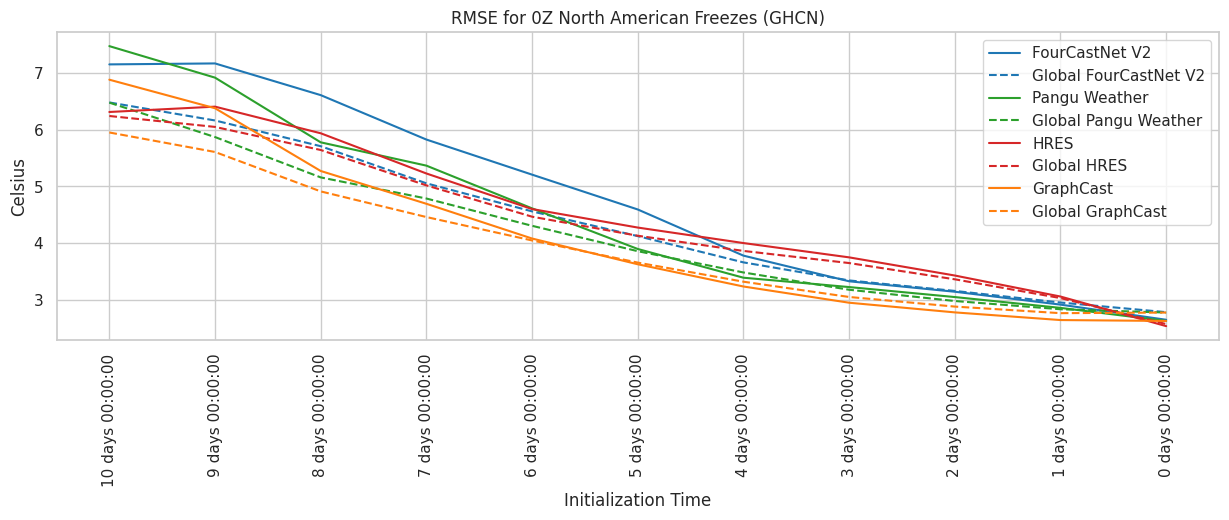

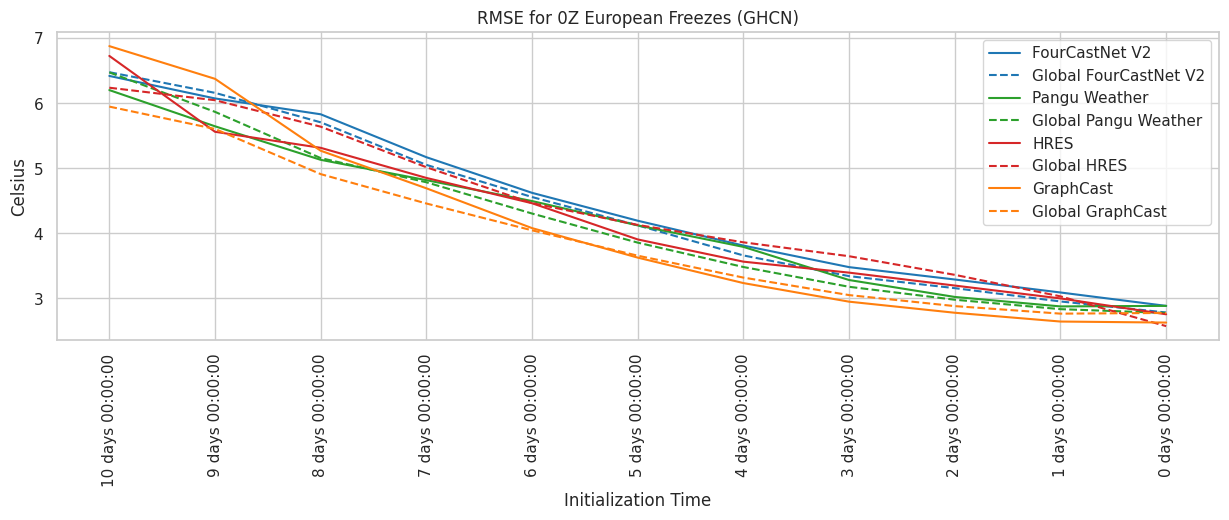

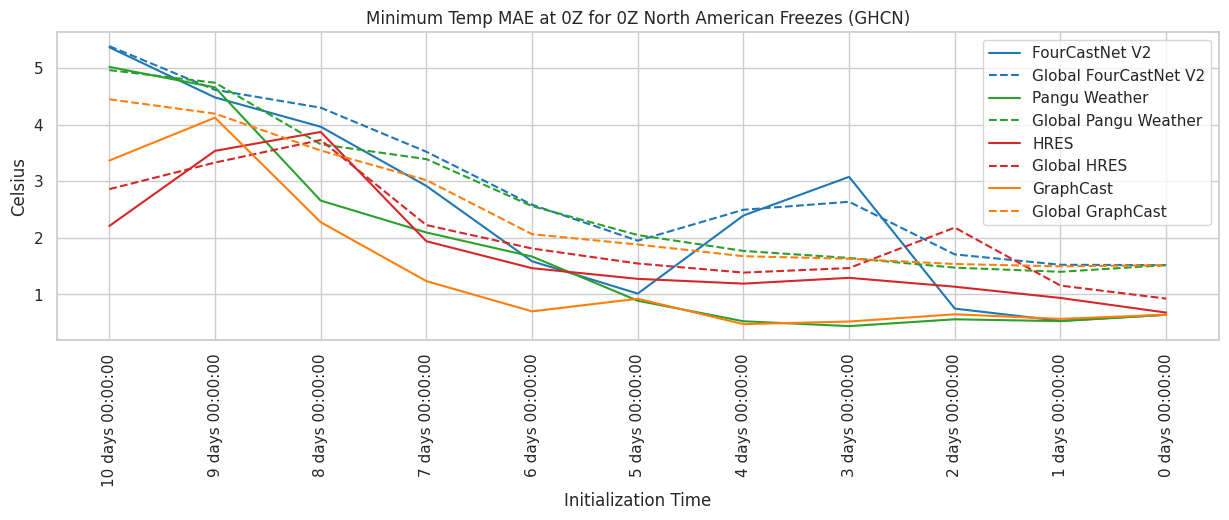

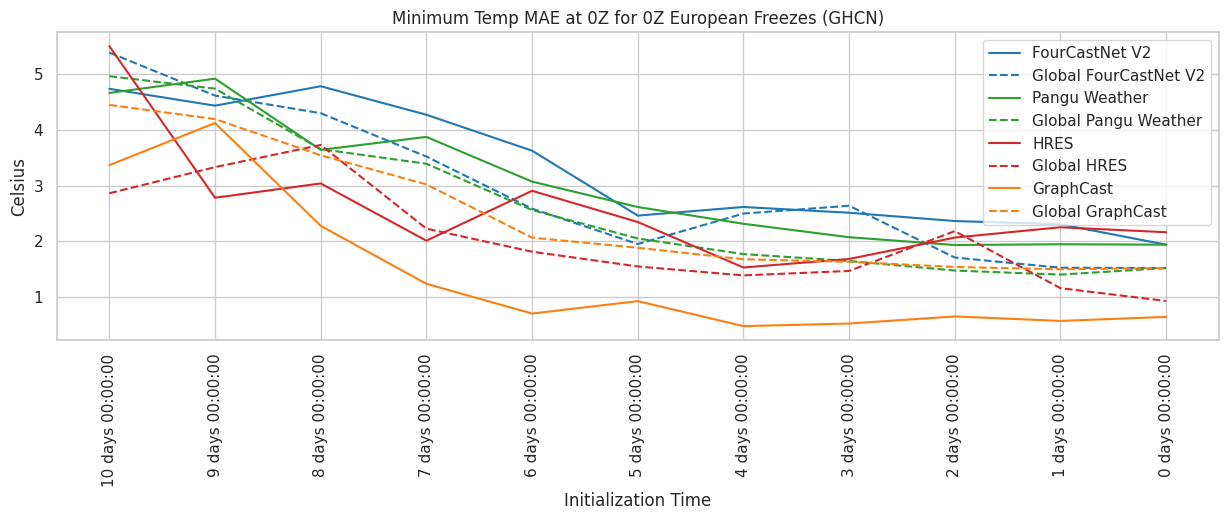

In [15]:
plot_results_by_metric(metric='rmse', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_na.png', title='RMSE for 0Z North American Freezes (GHCN)', 
                       fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results, 
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       forecast_hour='zeroz')

plot_results_by_metric(metric='rmse', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_eu.png', title='RMSE for 0Z European Freezes (GHCN)', 
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       fourv2_ghcn=eu_fourv2_ghcn_results, pang_ghcn=eu_pang_ghcn_results, hres_ghcn=eu_hres_ghcn_results, forecast_hour='zeroz')

plot_results_by_metric(metric='minimum_mae', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_na.png', 
                       title='Minimum Temp MAE at 0Z for 0Z North American Freezes (GHCN)', 
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results, forecast_hour='zeroz')

plot_results_by_metric(metric='minimum_mae', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_eu.png', 
                       title='Minimum Temp MAE at 0Z for 0Z European Freezes (GHCN)', 
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       fourv2_ghcn=eu_fourv2_ghcn_results, pang_ghcn=eu_pang_ghcn_results, hres_ghcn=eu_hres_ghcn_results, forecast_hour='zeroz')


In [20]:
# plot heatmaps
def plot_heatmap_results_by_metric(metric='rmse', filename=None, title='RMSE for All Heat Waves', 
                           fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results,
                           gc_ghcn=na_gc_ghcn_results,
                           global_fourv2_ghcn=fourv2_ghcn_results, global_pang_ghcn=pang_ghcn_results, global_hres_ghcn=hres_ghcn_results,
                           global_gc_ghcn=gc_ghcn_results,
                           forecast_hour=None):
    # make the pivot table so we can plot by lead time
    fourv2_ghcn_group = fourv2_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    fourv2_ghcn_pivot = fourv2_ghcn_group[fourv2_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    pang_ghcn_group = pang_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    pang_ghcn_pivot = pang_ghcn_group[pang_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    hres_ghcn_group = hres_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    hres_ghcn_pivot = hres_ghcn_group[hres_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    gc_ghcn_group = gc_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    gc_ghcn_pivot = gc_ghcn_group[gc_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    # grab the global results for reference lines
    global_fourv2_ghcn_group = global_fourv2_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_fourv2_ghcn_pivot = global_fourv2_ghcn_group[global_fourv2_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_pang_ghcn_group = global_pang_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_pang_ghcn_pivot = global_pang_ghcn_group[global_pang_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_hres_ghcn_group = global_hres_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_hres_ghcn_pivot = global_hres_ghcn_group[global_hres_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_gc_ghcn_group = global_gc_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_gc_ghcn_pivot = global_gc_ghcn_group[global_gc_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    if (forecast_hour == "zeroz"):
        # extract the 0z runs
        time_diff = fourv2_ghcn_pivot.columns.seconds % 86400 == 0
        my_times = [idx for idx, n in enumerate(time_diff) if n]

    elif (forecast_hour == "twelvez"):
        # extract the 12z runs
        time_diff = fourv2_ghcn_pivot.columns.seconds % 86400 == 43200
        my_times = [idx for idx, n in enumerate(time_diff) if n]

    if (forecast_hour is not None):
        fourv2_ghcn_pivot = fourv2_ghcn_pivot.iloc[:, my_times]
        pang_ghcn_pivot = pang_ghcn_pivot.iloc[:, my_times]
        hres_ghcn_pivot = hres_ghcn_pivot.iloc[:, my_times]
        gc_ghcn_pivot = gc_ghcn_pivot.iloc[:, my_times]

        global_fourv2_ghcn_pivot = global_fourv2_ghcn_pivot.iloc[:, my_times]
        global_pang_ghcn_pivot = global_pang_ghcn_pivot.iloc[:, my_times]
        global_hres_ghcn_pivot = global_hres_ghcn_pivot.iloc[:, my_times]  
        global_gc_ghcn_pivot = global_gc_ghcn_pivot.iloc[:, my_times]


    # make the plots
    sns.set_theme(style='whitegrid')
    fig, ax = plt.subplots(figsize=(15,10))
    fourv2_ghcn_values = fourv2_ghcn_pivot.loc[metric].values
    pang_ghcn_values = pang_ghcn_pivot.loc[metric].values
    hres_ghcn_values = hres_ghcn_pivot.loc[metric].values
    gc_ghcn_values = gc_ghcn_pivot.loc[metric].values

    global_fourv2_ghcn_values = global_fourv2_ghcn_pivot.loc[metric].values
    global_pang_ghcn_values = global_pang_ghcn_pivot.loc[metric].values
    global_hres_ghcn_values = global_hres_ghcn_pivot.loc[metric].values
    global_gc_ghcn_values = global_gc_ghcn_pivot.loc[metric].values

    # make an array of all the results as a float32 array
    all_results = np.array([fourv2_ghcn_values, pang_ghcn_values, gc_ghcn_values, hres_ghcn_values, 
                            global_fourv2_ghcn_values, global_pang_ghcn_values, global_gc_ghcn_values, global_hres_ghcn_values], dtype=np.float32)
    results_flipped = np.flip(all_results, axis=1)
    # create a heatmap with pcolormesh
    

    sns.heatmap(results_flipped, cmap='viridis_r', cbar_kws={'label': 'Celsius'}, square=True, annot=True, fmt='.2f',
                yticklabels=['FourCastNet V2', 'Pangu Weather', 'GraphCast', 'HRES', 'Global FourCastNet V2', 'Global Pangu Weather', 'Global GraphCast', 'Global HRES'], 
                xticklabels=np.flip(fourv2_ghcn_pivot.columns), ax=ax)
   
    plt.title(title)

    if (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)

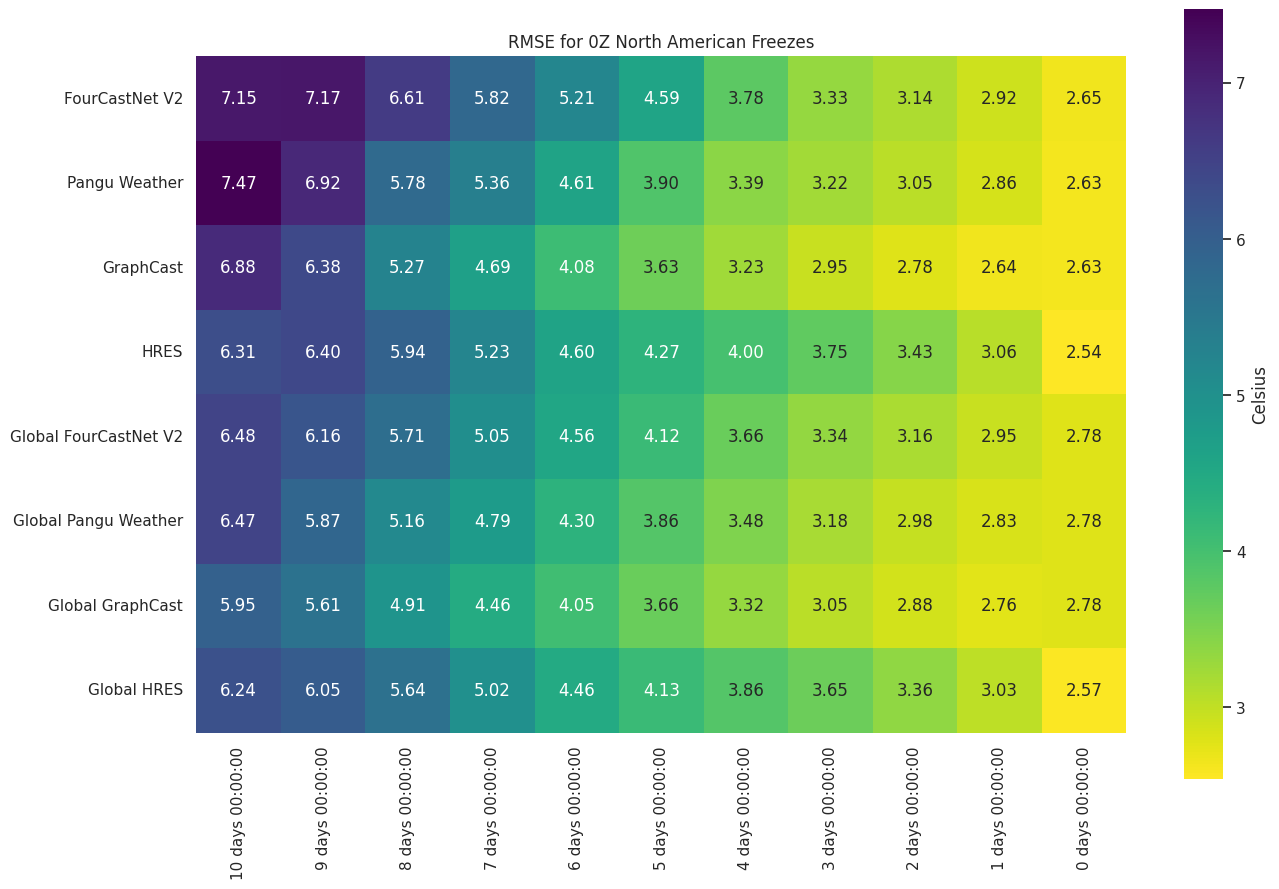

In [21]:
plot_heatmap_results_by_metric(metric='rmse', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_na.png', title='RMSE for 0Z North American Freezes', 
                       fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results, 
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       forecast_hour='zeroz')

# plot_results_by_metric(metric='rmse', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_eu.png', title='RMSE for 0Z European Freezes', 
#                        global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
#                        fourv2_ghcn=eu_fourv2_ghcn_results, pang_ghcn=eu_pang_ghcn_results, hres_ghcn=eu_hres_ghcn_results, forecast_hour='zeroz')

# plot_results_by_metric(metric='minimum_mae', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_na.png', 
#                        title='Minimum Temp MAE at 0Z for 0Z North American Freezes', 
#                        global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
#                        fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results, forecast_hour='zeroz')

# plot_results_by_metric(metric='minimum_mae', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_eu.png', 
#                        title='Minimum Temp MAE at 0Z for 0Z European Freezes', 
#                        global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
#                        fourv2_ghcn=eu_fourv2_ghcn_results, pang_ghcn=eu_pang_ghcn_results, hres_ghcn=eu_hres_ghcn_results, forecast_hour='zeroz')

In [22]:
# look through the north america cases to decide which one to look in depth
for freeze_case in ewb_cases.cases:
    
    if (freeze_case.case_id_number in na_cases):
        print(freeze_case)  

        #plot_all_cases(ewb_cases, event_type='freeze', bounding_box=na_bounding_box, fill_boxes=True, event_id=freeze_case.case_id_number)



IndividualCase(case_id_number=30, title='2021 Texas', start_date=datetime.datetime(2021, 2, 10, 12, 0), end_date=datetime.datetime(2021, 2, 22, 0, 0), location=BoundingBoxRegion(latitude_min=24.0, latitude_max=54.75, longitude_min=250.0, longitude_max=278.75), event_type='freeze')
IndividualCase(case_id_number=31, title='2022 Arkansas', start_date=datetime.datetime(2022, 2, 17, 18, 0), end_date=datetime.datetime(2022, 3, 1, 6, 0), location=BoundingBoxRegion(latitude_min=24.25, latitude_max=59.0, longitude_min=243.25, longitude_max=272.0), event_type='freeze')
IndividualCase(case_id_number=35, title='2022 Colorado', start_date=datetime.datetime(2022, 4, 6, 0, 0), end_date=datetime.datetime(2022, 4, 16, 0, 0), location=BoundingBoxRegion(latitude_min=35.25, latitude_max=64.0, longitude_min=236.75, longitude_max=261.5), event_type='freeze')
IndividualCase(case_id_number=89, title='January 2024 Pacific Northwest', start_date=datetime.datetime(2024, 1, 11, 12, 0), end_date=datetime.datetime(

In [16]:
# going to dive into case 31 in more detail
for case in ewb_cases.cases:
    if (case.case_id_number == 31):
        my_case = case
        print(my_case)
        break

IndividualCase(case_id_number=31, title='2022 Arkansas', start_date=datetime.datetime(2022, 2, 17, 18, 0), end_date=datetime.datetime(2022, 3, 1, 6, 0), location=BoundingBoxRegion(latitude_min=24.25, latitude_max=59.0, longitude_min=243.25, longitude_max=272.0), event_type='freeze')


In [28]:
def plot_individual_case_results_by_metric(metric='rmse', filename=None, title='RMSE for All Heat Waves', 
                           fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results,
                           gc_ghcn=na_gc_ghcn_results,
                           global_fourv2_ghcn=fourv2_ghcn_results, global_pang_ghcn=pang_ghcn_results, global_hres_ghcn=hres_ghcn_results,
                           global_gc_ghcn=gc_ghcn_results,
                           forecast_hour=None, event_id=None):
    
    # subset the results to just this metric and event id
    fourv2_ghcn = fourv2_ghcn[fourv2_ghcn['case_id_number'] == my_case.case_id_number]
    fourv2_ghcn = fourv2_ghcn[fourv2_ghcn['metric'] == metric]
    lead_times = fourv2_ghcn['lead_time'].values

    pang_ghcn = pang_ghcn[pang_ghcn['case_id_number'] == my_case.case_id_number]
    pang_ghcn = pang_ghcn[pang_ghcn['metric'] == metric]

    hres_ghcn = hres_ghcn[hres_ghcn['case_id_number'] == my_case.case_id_number]
    hres_ghcn = hres_ghcn[hres_ghcn['metric'] == metric]

    gc_ghcn = gc_ghcn[gc_ghcn['case_id_number'] == my_case.case_id_number]
    gc_ghcn = gc_ghcn[gc_ghcn['metric'] == metric]

    if (forecast_hour == "zeroz"):
        # extract the 0z runs
        my_times = [idx for idx, n in enumerate(lead_times) if n.seconds % 86400 == 0]
    elif (forecast_hour == "twelvez"):
        # extract the 12z runs
        my_times = [idx for idx, n in enumerate(lead_times) if n.seconds % 86400 == 43200]

    # if forecast hour is specified, grab the runs matching those times
    if (forecast_hour is not None):
        fourv2_ghcn = fourv2_ghcn.iloc[my_times]
        pang_ghcn = pang_ghcn.iloc[my_times]
        hres_ghcn = hres_ghcn.iloc[my_times] 
        gc_ghcn = gc_ghcn.iloc[my_times]   


     # grab the global results for reference lines
    global_fourv2_ghcn_group = global_fourv2_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_fourv2_ghcn_pivot = global_fourv2_ghcn_group[global_fourv2_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_pang_ghcn_group = global_pang_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_pang_ghcn_pivot = global_pang_ghcn_group[global_pang_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_hres_ghcn_group = global_hres_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_hres_ghcn_pivot = global_hres_ghcn_group[global_hres_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_gc_ghcn_group = global_gc_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_gc_ghcn_pivot = global_gc_ghcn_group[global_gc_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

     # if forecast hour is specified, grab the runs matching those times
    
    if (forecast_hour == "zeroz"):
        # extract the 0z runs
        time_diff = global_fourv2_ghcn_pivot.columns.seconds % 86400 == 0
        my_times = [idx for idx, n in enumerate(time_diff) if n]
    elif (forecast_hour == "twelvez"):
        # extract the 12z runs
        time_diff = global_fourv2_ghcn_pivot.columns.seconds % 86400 == 43200
        my_times = [idx for idx, n in enumerate(time_diff) if n]

    if (forecast_hour is not None):
        global_fourv2_ghcn_pivot = global_fourv2_ghcn_pivot.iloc[:, my_times]
        global_pang_ghcn_pivot = global_pang_ghcn_pivot.iloc[:, my_times]
        global_hres_ghcn_pivot = global_hres_ghcn_pivot.iloc[:, my_times]  
        global_gc_ghcn_pivot = global_gc_ghcn_pivot.iloc[:, my_times]



    #print(fourv2_ghcn)

    # make the plots
    sns.set_theme(style='whitegrid')
    fig, ax = plt.subplots(figsize=(15,4))
    fourv2_ghcn_values = fourv2_ghcn['value'].values
    pang_ghcn_values = pang_ghcn['value'].values
    hres_ghcn_values = hres_ghcn['value'].values
    gc_ghcn_values = gc_ghcn['value'].values

    global_fourv2_ghcn_values = global_fourv2_ghcn_pivot.loc[metric].values
    global_pang_ghcn_values = global_pang_ghcn_pivot.loc[metric].values
    global_hres_ghcn_values = global_hres_ghcn_pivot.loc[metric].values
    global_gc_ghcn_values = global_gc_ghcn_pivot.loc[metric].values

    #print(fourv2_ghcn_values)

    plt.plot(np.flip(fourv2_ghcn_values), color=fourv2_color, label='FourCastNet V2')
    plt.plot(np.flip(global_fourv2_ghcn_values), color=fourv2_color, linestyle=':', label='Global FourCastNet V2')

    plt.plot(np.flip(pang_ghcn_values), color=pangu_color, label='Pangu Weather')
    plt.plot(np.flip(global_pang_ghcn_values), color=pangu_color, linestyle=':', label='Global Pangu Weather')

    plt.plot(np.flip(hres_ghcn_values), color=hres_color, label='HRES')
    plt.plot(np.flip(global_hres_ghcn_values), color=hres_color, linestyle=':', label='Global HRES')

    plt.plot(np.flip(gc_ghcn_values), color=gc_color, label='GraphCast')
    plt.plot(np.flip(global_gc_ghcn_values), color=gc_color, linestyle=':', label='Global GraphCast')

    # make the xticklabels more readable and show every other one
    # print(np.arange(0, len(merged_pivot.columns), 2))
    # print(merged_pivot.columns[::2])
    ax.set_xticks(rotation=90, labels=np.flip(fourv2_ghcn['lead_time']), ticks=np.arange(0, len(fourv2_ghcn_values)))
    #ax.set_xticks(ticks=np.arange(0, len(merged_pivot.columns), 2))

    ax.set_ylabel('Celsius')
    ax.set_xlabel('Initialization Time')
    plt.title(title)
    #ax.grid(True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=0.5)
    plt.legend()

    if (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)

In [ ]:
global_fourv2_ghcn_group = fourv2_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
global_fourv2_ghcn_group[global_fourv2_ghcn_group['metric']=='rmse'].pivot(index='metric', columns='lead_time', values='value')

In [ ]:
na_fourv2_ghcn_results['metric'].unique()

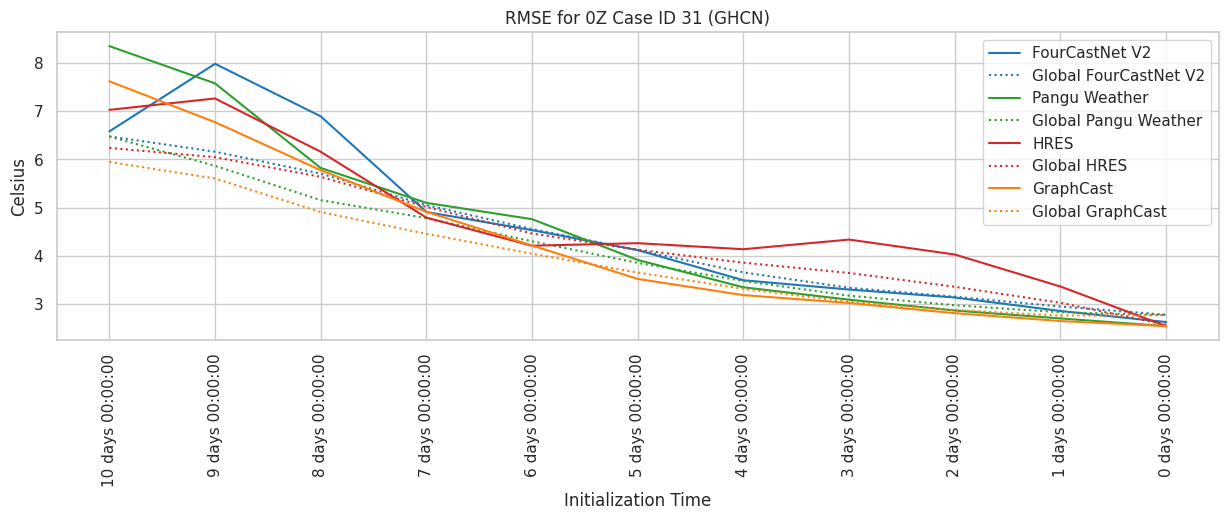

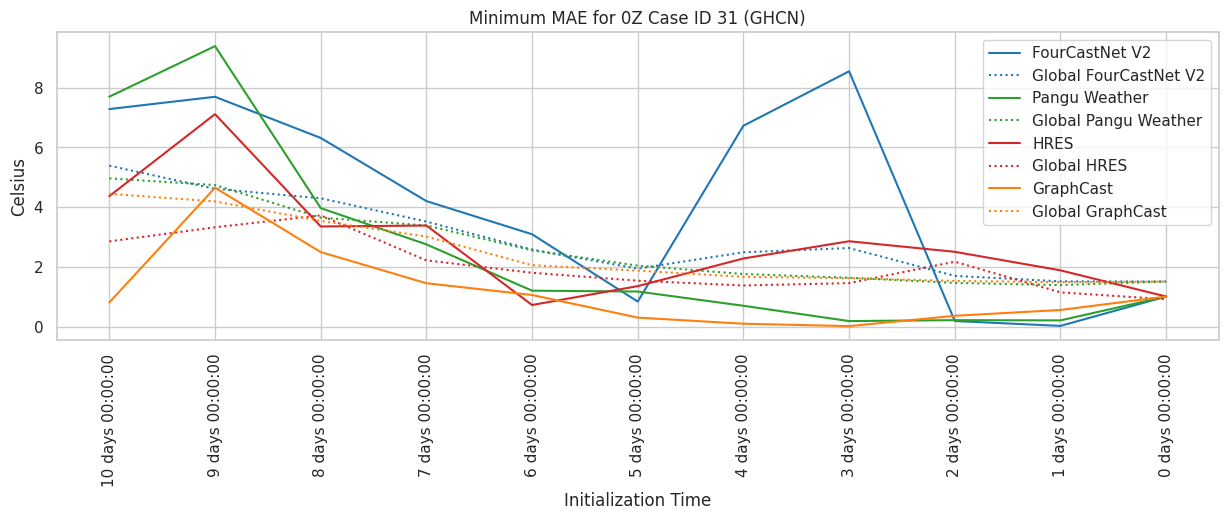

In [29]:
plot_individual_case_results_by_metric(metric='rmse', title='RMSE for 0Z Case ID 31 (GHCN)', 
                       fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results, 
                       gc_ghcn=na_gc_ghcn_results,
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       global_gc_ghcn=gc_ghcn_results,
                       forecast_hour='zeroz', event_id=my_case.case_id_number)

plot_individual_case_results_by_metric(metric='minimum_mae', title='Minimum MAE for 0Z Case ID 31 (GHCN)', 
                       fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results, 
                        gc_ghcn=na_gc_ghcn_results,
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                        global_gc_ghcn=gc_ghcn_results,
                       forecast_hour='zeroz', event_id=my_case.case_id_number)

/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'ls'
  result = super().contour(*args, **kwargs)


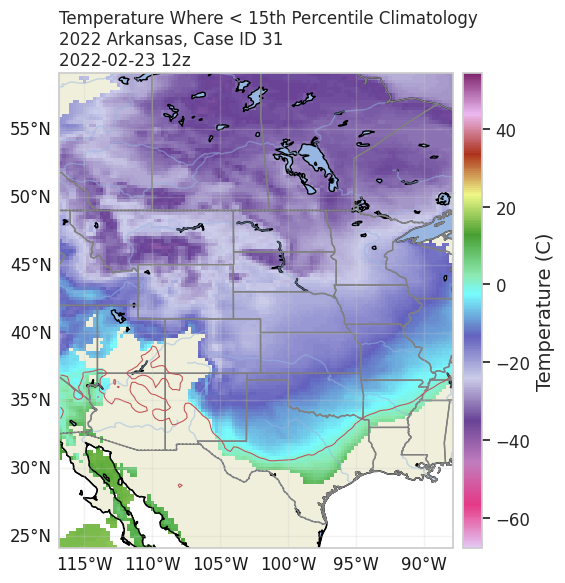

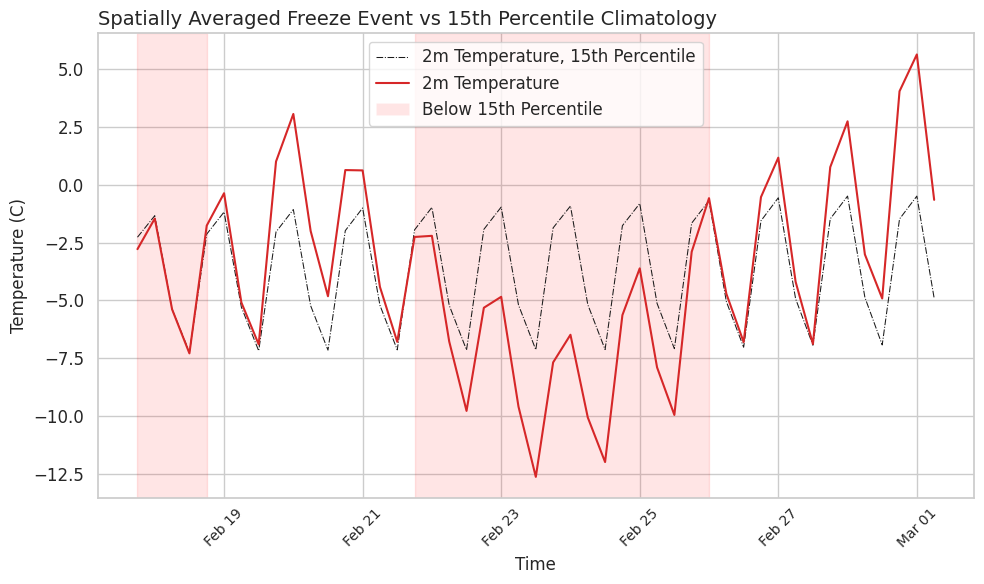

In [27]:
def celsius_colormap_and_normalize() -> tuple[mcolors.Colormap, mcolors.Normalize]:
    """Gets the colormap and normalization for 2m temperature.

    Uses a custom colormap for temperature in Celsius.

    Returns:
        A tuple (cmap, norm) for plotting.
    """
    lo_colors = [
        "#E4C7F4",
        "#E53885",
        "#C17CBE",
        "#694396",
        "#CBCCE9",
        "#6361BD",
        "#77FBFE",
    ]
    hi_colors = [
        "#8CE9B0",
        "#479F31",
        "#F0F988",
        "#AD311B",
        "#ECB9F1",
        "#7F266F",
    ]
    colors = lo_colors + hi_colors

    # Calculate the position where we want the 0C jump
    lo = -67.8  
    hi = 54.4  
    threshold = 0  
    threshold_pos = (threshold - lo) / (hi - lo)  # normalize 0°C position to [0,1]

    # Create positions for colors with a small gap around zero_pos
    positions = np.concatenate(
        [
            np.linspace(
                0, threshold_pos - 0.02, len(lo_colors)
            ),  # Colors up to white
            # [threshold_pos],  # White position
            np.linspace(
                threshold_pos + 0.02, 1, len(hi_colors)
            ),  # Colors after white
        ]
    )

    return mcolors.LinearSegmentedColormap.from_list(
        "temp_colormap", list(zip(positions, colors))
    ), mcolors.Normalize(vmin=lo, vmax=hi)


def convert_day_yearofday_to_time(dataset: xr.Dataset, year: int) -> xr.Dataset:
    """Convert dayofyear and hour coordinates in an xarray Dataset to a new time
    coordinate.

    Args:
        dataset: The input xarray dataset.
        year: The base year to use for the time coordinate.

    Returns:
        The dataset with a new time coordinate.
    """
    # Create a new time coordinate by combining dayofyear and hour
    time_dim = pd.date_range(
        start=f"{year}-01-01",
        periods=len(dataset["dayofyear"]) * len(dataset["hour"]),
        freq="6h",
    )
    dataset = dataset.stack(time=("dayofyear", "hour"))
    # Assign the new time coordinate to the dataset
    dataset = (dataset.drop_vars(['time', 'dayofyear', 'hour'])
               .assign_coords(time=time_dim))

    return dataset

def generate_freeze_dataset(
    era5: xr.Dataset,
    climatology: xr.Dataset,
    single_case: cases.IndividualCase,
):
    """Calculate the times where regional average of temperature is below the climatology.
    
    Args:
        era5: ERA5 dataset containing 2m_temperature
        climatology: BB climatology containing surface_temperature_15th_percentile
        single_case: cases.IndividualCase object with associated metadata
    """
    era5_case = era5[["2m_temperature"]].sel(
        time=slice(single_case.start_date, single_case.end_date)
    )
    subset_climatology = convert_day_yearofday_to_time(
        climatology, np.unique(era5_case.time.dt.year.values)[0]
    )
    merged_dataset = xr.merge(
        [
            subset_climatology.rename(
                {"2m_temperature": "surface_temperature_15th_percentile"}
            ),
            era5_case,
        ],
        join="inner",
    )
    if (
        single_case.location.longitude_min < 0 or 
        single_case.location.longitude_min > 180 
        ) and (
        single_case.location.longitude_max > 0 and
        single_case.location.longitude_max < 180
            ):
                merged_dataset = utils.convert_longitude_to_180(merged_dataset)
    merged_dataset = merged_dataset.sel(
        latitude=slice(single_case.location.latitude_max, single_case.location.latitude_min),
        longitude=slice(single_case.location.longitude_min, single_case.location.longitude_max),
    )
    return merged_dataset

def generate_freeze_plots(
    freeze_dataset: xr.Dataset,
    single_case: cases.IndividualCase,
):
    """Plot the max timestep of the freeze event and the average regional temperature time series
    on separate plots.
    
    Args:
        freeze_dataset: contains 2m_temperature, surface_temperature_15th_percentile,
        time, latitude, longitude
        single_case: cases.IndividualCase object with associated metadata
    """
    time_based_freeze_dataset = freeze_dataset.mean(["latitude", "longitude"])
    # Plot 1: Min timestep of the freeze event
    fig1, ax1 = plt.subplots(
        figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    # Select the timestep with the maximum spatially averagedtemperature
    subset_timestep = (
        time_based_freeze_dataset['time'][time_based_freeze_dataset["2m_temperature"]
        .argmin()]
    )
    # Mask places where temperature >= 15th percentile climatology
    temp_data = freeze_dataset["2m_temperature"] - 273.15
    climatology_data = freeze_dataset["surface_temperature_15th_percentile"] - 273.15
    
    # Create mask for values where temp < climatology (freeze condition)
    mask = temp_data < climatology_data
    
    # Apply mask to temperature data
    masked_temp = temp_data.where(mask)
    cmap, norm = celsius_colormap_and_normalize()
    im = (
        masked_temp
        .sel(time=subset_timestep)
        .plot(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            add_colorbar=False,
        )
    )
    (
        temp_data
        .sel(time=subset_timestep)
        .plot.contour(
            ax=ax1,
            levels=[0],
            colors='r',
            linewidths=0.75,
            ls=':',
            transform=ccrs.PlateCarree(),
        )
    )   
    # Add coastlines and gridlines
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS, linestyle=":")
    ax1.add_feature(cfeature.LAND, edgecolor="black")
    ax1.add_feature(cfeature.LAKES, edgecolor="black")
    ax1.add_feature(cfeature.RIVERS, edgecolor=[ 0.59375 , 0.71484375, 0.8828125 ],alpha=0.5)
    ax1.add_feature(cfeature.STATES, edgecolor="grey")
    # Add gridlines
    gl = ax1.gridlines(draw_labels=True,alpha=0.25)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlabel_style = {"size": 12, "color": "k"}
    gl.ylabel_style = {"size": 12, "color": "k"}
    ax1.set_title('') # clears the default xarray title
    ax1.set_title(
        f"Temperature Where < 15th Percentile Climatology\n"
        f"{single_case.title}, Case ID {single_case.case_id_number}\n"
        f"{freeze_dataset['time'].sel(time=subset_timestep).dt.strftime('%Y-%m-%d %Hz').values}", 
        loc='left'
    )
    # Add the location coordinate as a dot on the map
    ax1.tick_params(axis='y', which='major', labelsize=12)
    # Create a colorbar with the same height as the plot
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    cbar = fig1.colorbar(im, cax=cax, label="Temp < 15th Percentile (C)")
    cbar.set_label("Temperature (C)", size=14)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.savefig(f"case_{single_case.case_id_number}_spatial.png",transparent=True)
    plt.show()

    # Plot 2: Average regional temperature time series
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    lss = ["-.", "-"]
    lc = ["k", "tab:red"]
    lws = [0.75, 1.5]
    for i, variable in enumerate(time_based_freeze_dataset):
        (time_based_freeze_dataset[variable] - 273.15).plot(
            ax=ax2, label=variable, lw=lws[i], ls=lss[i], c=lc[i]
        )
    ax2.legend(fontsize=12)
    mask = (
        time_based_freeze_dataset["2m_temperature"]
        < time_based_freeze_dataset["surface_temperature_15th_percentile"]
    )
    start = None
    for i, val in enumerate(mask.values):
        if val and start is None:
            start = time_based_freeze_dataset.time[i].values
        elif not val and start is not None:
            ax2.axvspan(
                start,
                time_based_freeze_dataset.time[i].values,
                color="red",
                alpha=0.1,
            )
            start = None
    if start is not None:
        ax2.axvspan(
            start, time_based_freeze_dataset.time[-1].values, color="red", alpha=0.1
        )
    ax2.set_title('')
    ax2.set_title("Spatially Averaged Freeze Event vs 15th Percentile Climatology", 
    fontsize=14, loc='left')
    ax2.set_ylabel("Temperature (C)", fontsize=12)
    ax2.set_xlabel("Time", fontsize=12)
    ax2.tick_params(axis="x", labelsize=12)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax2.xaxis.set_tick_params(rotation=45, labelsize=10, pad=0.0001,)
    ax2.tick_params(axis="y", labelsize=12)
    
    # Create legend handles including the axvspan
    from matplotlib.patches import Patch
    legend_elements = [
        plt.Line2D([0], [0], color='k', linestyle='-.', linewidth=0.75, 
                   label='2m Temperature, 15th Percentile'),
        plt.Line2D([0], [0], color='tab:red', linestyle='-', linewidth=1.5, 
                   label='2m Temperature'),
        Patch(facecolor='red', alpha=0.1, label='Below 15th Percentile')
    ]
    ax2.legend(handles=legend_elements, fontsize=12)
    
    ax2.tick_params(axis='y', which='major', labelsize=12)
    plt.tight_layout()
    plt.savefig(f"case_{single_case.case_id_number}_timeseries.png",transparent=True)
    plt.show()

era5 = defaults.era5_freeze_target.open_and_maybe_preprocess_data_from_source()
temp_climatology_ds = xr.open_zarr('gs://extremeweatherbench/datasets/surface_air_temperature_1990_2019_climatology.zarr/')
temp_climatology_ds = temp_climatology_ds.sel(quantile=0.15)
# # load in all of the events in the yaml file
# case_dict = utils.load_events_yaml()
# ewb_case = cases.load_individual_cases(case_dict)
# ewb_case = [n for n in ewb_case.cases if n.event_type == "freeze"][0]
freeze_dataset = generate_freeze_dataset(era5, temp_climatology_ds, my_case)
generate_freeze_plots(freeze_dataset, my_case)